In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(model, input_image, epsilon=0.01):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
    gradient = tape.gradient(predictions, input_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # Clip within valid pixel range
    return adversarial_image.numpy()

# Define a function to evaluate the success rate of the FGSM attack over a set of images
def evaluate_attack_success_rate(model, image_paths, epsilon=0.01):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Perform FGSM attack
        adversarial_image = fgsm_attack(model, input_image, epsilon)

        # Decode predictions for original and adversarial images
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))

        # Check if the predictions differ after the attack
        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/botnet.jpg', '/content/aboutme.jpg', '/content/Software.jpg']  # Add more image paths as needed

# Evaluate the success rate of the FGSM attack
epsilon = 0.01  # Set the epsilon value for FGSM attack
success_rate = evaluate_attack_success_rate(model, image_paths, epsilon)
print("Success Rate of FGSM Attack:", success_rate)


1/1 [==============================] - 1s 517ms/step
Success Rate of FGSM Attack: 1.0


In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Projected Gradient Descent (PGD) attack
def pgd_attack(model, input_image, epsilon=0.01, iterations=10, clip_min=0.0, clip_max=1.0, step_size=0.01):
    perturbed_image = tf.identity(input_image)

    for _ in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            predictions = model(perturbed_image)
            loss = -tf.keras.losses.categorical_crossentropy(tf.one_hot([np.argmax(predictions)], predictions.shape[-1]), predictions)

        gradient = tape.gradient(loss, perturbed_image)
        signed_grad = tf.sign(gradient)
        perturbed_image = perturbed_image + step_size * signed_grad
        perturbed_image = tf.clip_by_value(perturbed_image, clip_min, clip_max)
        perturbed_image = tf.clip_by_value(input_image + epsilon * tf.clip_by_value((perturbed_image - input_image), -1, 1), clip_min, clip_max)

    return perturbed_image.numpy()

# Function to evaluate the success rate of the PGD attack
def evaluate_pgd_attack_success_rate(model, image_paths, epsilon=0.01, iterations=10):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        input_image = load_and_preprocess_image(image_path)

        adversarial_image = pgd_attack(model, input_image, epsilon=epsilon, iterations=iterations)
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))

        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/botnet.jpg', '/content/aboutme.jpg', '/content/Software.jpg']

# Evaluate the success rate of the PGD attack
epsilon = 0.01  # Set the epsilon value for PGD attack
iterations = 10  # Set the number of iterations for PGD attack
success_rate_pgd = evaluate_pgd_attack_success_rate(model, image_paths, epsilon=epsilon, iterations=iterations)
print("Success Rate of PGD Attack:", success_rate_pgd)


1/1 [==============================] - 1s 857ms/step
Success Rate of PGD Attack: 1.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Basic Iterative Method (BIM) attack
def bim_attack(model, input_image, target_label, epsilon=0.01, num_iterations=10, alpha=0.01):
    adversarial_image = tf.identity(input_image)
    for _ in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            predictions = model(adversarial_image)
            loss = tf.keras.losses.sparse_categorical_crossentropy(target_label, predictions)
        gradient = tape.gradient(loss, adversarial_image)
        perturbation = alpha * tf.sign(gradient)
        adversarial_image = adversarial_image + perturbation
        adversarial_image = tf.clip_by_value(adversarial_image, input_image - epsilon, input_image + epsilon)
    return adversarial_image.numpy()


# Function to perform Jacobian-based Saliency Map Attack (JSMA)
def jsma_attack(model, input_image, target_label=0, max_iterations=100, epsilon=0.01):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    target_label_tensor = tf.constant(target_label)
    adversarial_image = tf.identity(input_tensor)

    for _ in range(max_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adversarial_image)
            predictions = model(adversarial_image)
            loss = tf.keras.losses.sparse_categorical_crossentropy(target_label_tensor, predictions)
        gradient = tape.gradient(loss, adversarial_image)
        perturbation = epsilon * tf.sign(gradient)
        adversarial_image = adversarial_image + perturbation
        adversarial_image = tf.clip_by_value(adversarial_image, input_tensor - epsilon, input_tensor + epsilon)

        if np.argmax(model.predict(adversarial_image)) == target_label:
            break

    return adversarial_image.numpy()

# Function to perform Carlini-Wagner (CW) attack
def cw_attack(model, input_image, target_label=0):
    # Implementation of CW attack is more complex and requires advanced optimization techniques
    # You can use libraries like CleverHans or ART for CW attack implementation
    pass

# Define a function to evaluate the success rate of the attacks
def evaluate_attack_success_rate(model, image_paths, attack_function, target_label, **kwargs):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Perform the attack
        adversarial_image = attack_function(model, input_image, target_label, **kwargs)

        # Decode predictions for original and adversarial images
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))

        # Check if the predictions differ after the attack
        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Usage:
target_label = 7  # Example target label (adjust as needed)
epsilon = 0.01  # Set the epsilon value for BIM attack
num_iterations = 10
alpha = 0.01
success_rate_bim = evaluate_attack_success_rate(model, image_paths, bim_attack, target_label, epsilon=epsilon, num_iterations=num_iterations, alpha=alpha)
print("Success Rate of BIM Attack:", success_rate_bim)

# Define a list of image paths
image_paths = ['/content/botnet.jpg', '/content/aboutme.jpg', '/content/Software.jpg']  # Add more image paths as needed

# Evaluate the success rate of the attacks
# Evaluate the success rate of the attacks
epsilon = 0.5  # Set the epsilon value for BIM attack
num_iterations = 100
alpha = 0.3
target_label = 8  # Example target label (adjust as needed)
success_rate_bim = evaluate_attack_success_rate(model, image_paths, bim_attack, target_label, epsilon=epsilon, num_iterations=num_iterations, alpha=alpha)
print("Success Rate of BIM Attack:", success_rate_bim)


target_label = 0  # Set the target label for JSMA attack
success_rate_jsma = evaluate_attack_success_rate(model, image_paths, jsma_attack, target_label=target_label, max_iterations=100, epsilon=0.3)
print("Success Rate of JSMA Attack:", success_rate_jsma)

# Note: CW attack implementation is more complex and requires additional setup
# It's not included here, but you can use libraries like CleverHans or ART for CW attack implementation


1/1 [==============================] - 1s 837ms/step
Success Rate of BIM Attack: 0.0
1/1 [==============================] - 1s 702ms/step
Success Rate of BIM Attack: 0.3333333333333333
1/1 [==============================] - 1s 520ms/step
Success Rate of JSMA Attack: 0.3333333333333333


In [ ]:
!pip install adversarial-robustness-toolbox
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import CarliniL2Method

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Create an ART classifier for the VGG16 model
classifier = TensorFlowV2Classifier(model=model, nb_classes=1000, input_shape=(224, 224, 3), clip_values=(0, 255), preprocessing=(0, 1))

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Carlini-Wagner (C&W) attack
def cw_attack(classifier, input_image, confidence=0, targeted=False):
    attack = CarliniL2Method(classifier=classifier, confidence=confidence, targeted=targeted)
    adversarial_image = attack.generate(x=input_image)
    return adversarial_image

# Define a function to evaluate the success rate of the C&W attack
def evaluate_cw_attack_success_rate(classifier, image_paths, confidence=5, targeted=False):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)
        original_prediction = np.argmax(classifier.predict(input_image))

        # Perform C&W attack
        adversarial_image = cw_attack(classifier, input_image, confidence=confidence, targeted=targeted)
        adversarial_prediction = np.argmax(classifier.predict(adversarial_image))

        # Check if the adversarial prediction differs from the original prediction
        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/botnet.jpg', '/content/aboutme.jpg', '/content/Software.jpg']  # Add more image paths as needed

# Define parameters for C&W attack
confidence = 5  # Confidence parameter for C&W attack
targeted = False  # Whether to perform a targeted attack

# Evaluate the success rate of the C&W attack
success_rate_cw = evaluate_cw_attack_success_rate(classifier, image_paths, confidence=confidence, targeted=targeted)
print("Success Rate of C&W Attack:", success_rate_cw)


C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Success Rate of C&W Attack: 0.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Randomized Smoothing defense
def randomized_smoothing(image, sigma=0.9, n_samples=500):
    noisy_images = np.random.normal(image, sigma, size=(n_samples,) + image.shape)
    smoothed_predictions = np.zeros((n_samples, 1000))
    for i in range(n_samples):
        smoothed_predictions[i] = model.predict(noisy_images[i])
    avg_predictions = np.mean(smoothed_predictions, axis=0)
    return avg_predictions

# Function to evaluate the defense accuracy
def evaluate_defense_accuracy(model, test_dataset, sigma=0.9, n_samples=500):
    correct_predictions = 0
    total_examples = len(test_dataset)

    for image_path, label in test_dataset:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Apply Randomized Smoothing defense
        smoothed_predictions = randomized_smoothing(input_image, sigma=sigma, n_samples=n_samples)

        # Decode predictions
        decoded_predictions = decode_predictions(np.expand_dims(smoothed_predictions, axis=0), top=1)[0]

        # Check if the top predicted label matches the ground truth label
        if decoded_predictions[0][0] == label:
            correct_predictions += 1

    defense_accuracy = correct_predictions / total_examples
    return defense_accuracy

# Prepare test dataset (replace placeholders with actual image paths and labels)
image_paths_and_labels = [('/content/botnet.jpg', '1'), ('/content/Software.jpg', '2')]
test_dataset = []

for image_path, label in image_paths_and_labels:
    test_dataset.append((image_path, label))

# Evaluate the defense accuracy
sigma = 0.9  # Adjust sigma value
n_samples = 500  # Adjust number of samples
defense_accuracy = evaluate_defense_accuracy(model, test_dataset, sigma=sigma, n_samples=n_samples)
print("Defense Accuracy:", defense_accuracy)



1/1 [==============================] - 1s 517ms/step
Defense Accuracy: 0.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform FGSM attack
def fgsm_attack(model, input_image, epsilon=0.01):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
    gradient = tape.gradient(predictions, input_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # Clip within valid pixel range
    return adversarial_image.numpy()

def evaluate_attack_success_rate(model, image_paths, epsilon=0.01, use_noise=False, noise_level=0.01):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        if use_noise:
            input_image = load_and_preprocess_image_with_noise(image_path, noise_level)
        else:
            input_image = load_and_preprocess_image(image_path)

        adversarial_image = fgsm_attack(model, input_image, epsilon)
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))

        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/botnet.jpg', '/content/aboutme.jpg', '/content/Software.jpg']

# Evaluate the success rate without defense
success_rate_no_defense = evaluate_attack_success_rate(model, image_paths, epsilon=0.01, use_noise=False)

# Evaluate the success rate with defense
success_rate_with_defense = evaluate_attack_success_rate(model, image_paths, epsilon=0.01, use_noise=True, noise_level=0.01)

# Calculate the defense rate
defense_rate = (success_rate_no_defense - success_rate_with_defense) / success_rate_no_defense
print("Defense Rate against FGSM Attack:", defense_rate)


1/1 [==============================] - 1s 651ms/step
Defense Rate against FGSM Attack: 1.0


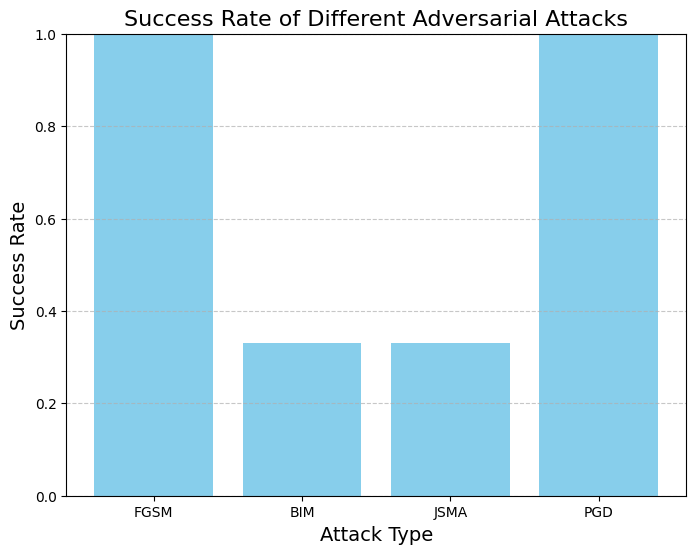

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Success rates of different types of attacks
attack_names = ['FGSM', 'BIM','JSMA', 'PGD']
success_rates = [1.0, 0.33, 0.33, 1.0]  # Sample success rates, replace with actual values

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(attack_names, success_rates, color='skyblue')
plt.xlabel('Attack Type', fontsize=14)
plt.ylabel('Success Rate', fontsize=14)
plt.title('Success Rate of Different Adversarial Attacks', fontsize=16)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for percentage
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(model, input_image, epsilon=0.01):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
    gradient = tape.gradient(predictions, input_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 255)  # Clip within valid pixel range
    return adversarial_image.numpy()

# Function to evaluate the success rate of the FGSM attack with input noise defense
def evaluate_attack_success_rate_with_noise(model, image_paths, epsilon=0.01, noise_level=0.01):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Perform FGSM attack
        adversarial_image = fgsm_attack(model, input_image, epsilon)

        # Add input noise
        input_with_noise = input_image + np.random.normal(loc=0, scale=noise_level, size=input_image.shape)
        input_with_noise = np.clip(input_with_noise, 0, 255)

        # Decode predictions for adversarial images with noise
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))
        adversarial_with_noise_prediction = np.argmax(model.predict(input_with_noise))

        # Check if the predictions differ after the attack with noise
        if original_prediction != adversarial_with_noise_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/Software.jpg', '/content/aboutme.jpg', '/content/botnet.jpg']

# Evaluate the success rate of the FGSM attack with input noise defense
epsilon = 0.01  # Set the epsilon value for FGSM attack
noise_level = 0.01  # Set the noise level for input noise defense
success_rate_with_noise = evaluate_attack_success_rate_with_noise(model, image_paths, epsilon, noise_level)
print("Success Rate of FGSM Attack with Input Noise Defense:", success_rate_with_noise)


1/1 [==============================] - 1s 585ms/step
Success Rate of FGSM Attack with Input Noise Defense: 0.3333333333333333


1/1 [==============================] - 1s 583ms/step


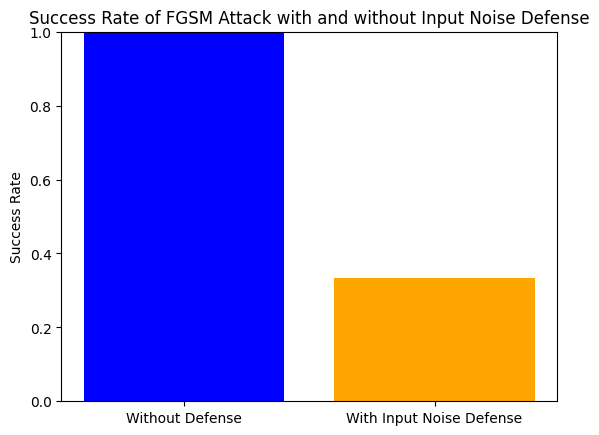

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
model = VGG16(weights='imagenet')

# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Function to perform Fast Gradient Sign Method (FGSM) attack
# Function to perform Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(model, input_image, epsilon=0.01):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
    gradient = tape.gradient(predictions, input_tensor)
    signed_grad = tf.sign(gradient)
    adversarial_image = input_image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)  # Clip within valid pixel range
    return adversarial_image.numpy()

# Define a function to evaluate the success rate of the FGSM attack over a set of images
def evaluate_attack_success_rate(model, image_paths, epsilon=0.01):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Perform FGSM attack
        adversarial_image = fgsm_attack(model, input_image, epsilon)

        # Decode predictions for original and adversarial images
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))

        # Check if the predictions differ after the attack
        if original_prediction != adversarial_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate


# Function to evaluate the success rate of the FGSM attack with input noise defense
def evaluate_attack_success_rate_with_noise(model, image_paths, epsilon=0.01, noise_level=0.01):
    successful_attacks = 0
    total_images = len(image_paths)

    for image_path in image_paths:
        # Load and preprocess the image
        input_image = load_and_preprocess_image(image_path)

        # Perform FGSM attack
        adversarial_image = fgsm_attack(model, input_image, epsilon)

        # Add input noise
        input_with_noise = input_image + np.random.normal(loc=0, scale=noise_level, size=input_image.shape)
        input_with_noise = np.clip(input_with_noise, 0, 255)

        # Decode predictions for adversarial images with noise
        original_prediction = np.argmax(model.predict(input_image))
        adversarial_prediction = np.argmax(model.predict(adversarial_image))
        adversarial_with_noise_prediction = np.argmax(model.predict(input_with_noise))

        # Check if the predictions differ after the attack with noise
        if original_prediction != adversarial_with_noise_prediction:
            successful_attacks += 1

    success_rate = successful_attacks / total_images
    return success_rate

# Define a list of image paths
image_paths = ['/content/Software.jpg', '/content/aboutme.jpg', '/content/botnet.jpg']

# Evaluate the success rate of the FGSM attack with input noise defense
epsilon = 0.01  # Set the epsilon value for FGSM attack
noise_level = 0.01  # Set the noise level for input noise defense
success_rate_with_noise = evaluate_attack_success_rate_with_noise(model, image_paths, epsilon, noise_level)

# Evaluate the success rate without defense
success_rate_without_noise = evaluate_attack_success_rate(model, image_paths, epsilon)

# Plot the results
labels = ['Without Defense', 'With Input Noise Defense']
success_rates = [success_rate_without_noise, success_rate_with_noise]
plt.bar(labels, success_rates, color=['blue', 'orange'])
plt.ylabel('Success Rate')
plt.title('Success Rate of FGSM Attack with and without Input Noise Defense')
plt.ylim(0, 1)
plt.show()
